In [1]:
import pandas as pd
from scipy import stats
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
with open('../data/gene_lists/mouse_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role

In [3]:
senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist()
senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}

In [4]:
markers = markers | senmayo

In [5]:
temp = pd.read_csv('../data/gene_lists/elife-62293-supp3-v2-1_aging_sig.csv') #this file has global aging signature doi.org/10.6084/m9.figshare.12827615.v1
gags = list(temp[temp.global_aging == 1].gene.values)

In [6]:
len(gags)

330

In [7]:
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data.h5ad')

In [8]:
len([x for x in gags if x in list(markers)]) #how many gags and sen markers overlap?

3

In [9]:
[x for x in gags if x in list(markers)]

['Cd9', 'Ctnnb1', 'Jun']

In [10]:
stats.hypergeom.sf(3-1, len(adata.var_names), len(gags) , len(markers))

0.5838505236928658

In [11]:
#cell-type specific aging signature overlap with sen markers

df = pd.read_csv('../data/gene_lists/elife-62293-supp2-v2-1_aging_genes.csv')




def tissue_gene_lis(tissue_cell):
    return list(df[df[tissue_cell] == 1].gene.values)

global_gene_len = len(adata.var_names)

sen_age_overlap = []
for tissue_cell in [x for x in df.columns if x != 'gene']:
    gene_lis = tissue_gene_lis(tissue_cell)
    overlap = len([x for x in list(markers) if x in gene_lis])
    
    p = stats.hypergeom.sf(overlap-1, global_gene_len, len(markers), len(gene_lis))
    
    sen_age_overlap.append([tissue_cell, len(gene_lis),overlap, p, ','.join(gene_lis)])
    
    
sen_age_overlap = pd.DataFrame(sen_age_overlap, columns = ['tissue_cell', 'aging_genes','overlap', 'geo_p','genes'])

sen_age_overlap['per_a_to_s'] = (sen_age_overlap.overlap/sen_age_overlap.aging_genes) * 100
sen_age_overlap['per_sen'] = (sen_age_overlap.overlap/len(markers)) * 100
sen_age_overlap['tissue'] = sen_age_overlap['tissue_cell'].map(lambda x: x.split('.')[0])



#save order
temp = dict(zip(sen_age_overlap.tissue_cell, sen_age_overlap.index))

sen_age_overlap = sen_age_overlap.sort_values('geo_p')
sen_age_overlap = sen_age_overlap.reset_index(drop = True)
sen_age_overlap['BH'] = sen_age_overlap.geo_p * len(sen_age_overlap)

sen_age_overlap['Order'] = sen_age_overlap.tissue_cell.map(temp)
sen_age_overlap = sen_age_overlap.sort_values('Order').reset_index(drop = True)


In [12]:
df

,gene,Aorta.aortic endothelial cell,BAT.B cell,BAT.endothelial cell,BAT.myeloid cell,Bladder.bladder cell,Bladder.bladder urothelial cell,Brain_Myeloid.microglial cell,Brain_Non-Myeloid.astrocyte,Brain_Non-Myeloid.brain pericyte,...,Spleen.B cell,"Spleen.CD4-positive, alpha-beta T cell","Spleen.CD8-positive, alpha-beta T cell",Thymus.DN4 thymocyte,Thymus.thymocyte,Tongue.basal cell of epidermis,Tongue.keratinocyte,Trachea.endothelial cell,Trachea.fibroblast,Trachea.macrophage
0,0610005C13Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0610007C21Rik,0,0,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0610007L01Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0610007N19Rik,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0610007P08Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13371,Zxdc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13372,Zyg11b,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,1
13373,Zyx,0,0,0,1,0,1,0,0,1,...,0,0,1,1,1,0,0,1,0,0
13374,Zzef1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
sen_age_overlap

,tissue_cell,aging_genes,overlap,geo_p,genes,per_a_to_s,per_sen,tissue,BH,Order
0,Aorta.aortic endothelial cell,1300,25,3.421669e-04,"0610009O20Rik,1190002H23Rik,1200011M11Rik,1700...",1.923077,13.586957,Aorta,0.026005,0
1,BAT.B cell,424,12,5.516384e-04,"1110003E01Rik,1110057K04Rik,1500003O03Rik,2010...",2.830189,6.521739,BAT,0.041925,1
2,BAT.endothelial cell,487,9,3.555494e-02,"0610007C21Rik,0610012G03Rik,1110003E01Rik,1110...",1.848049,4.891304,BAT,2.702175,2
3,BAT.myeloid cell,1270,25,2.408344e-04,"0610007C21Rik,1100001G20Rik,1110005A03Rik,1110...",1.968504,13.586957,BAT,0.018303,3
4,Bladder.bladder cell,1999,43,7.490523e-08,"0610007N19Rik,0610031J06Rik,1110002B05Rik,1110...",2.151076,23.369565,Bladder,0.000006,4
...,...,...,...,...,...,...,...,...,...,...
71,Tongue.basal cell of epidermis,2941,27,5.238363e-01,"0610009D07Rik,0610011L14Rik,0610031J06Rik,0910...",0.918055,14.673913,Tongue,39.811560,71
72,Tongue.keratinocyte,2583,18,9.167467e-01,"0610009D07Rik,0610011L14Rik,0610037L13Rik,0910...",0.696864,9.782609,Tongue,69.672752,72
73,Trachea.endothelial cell,1725,21,1.087476e-01,"0610031J06Rik,1110003E01Rik,1110018J18Rik,1110...",1.217391,11.413043,Trachea,8.264815,73
74,Trachea.fibroblast,2587,39,1.045912e-03,"0610007L01Rik,0610007N19Rik,0610010K14Rik,0910...",1.507538,21.195652,Trachea,0.079489,74


In [14]:
len(sen_age_overlap[sen_age_overlap.BH < 0.05]) #how many less enriched 

15

In [15]:
#add proliferation score
facs = adata[adata.obs.method == 'facs']
out = []
for i, row in sen_age_overlap.iterrows():
    temp = facs[(facs.obs.cell_ontology_class == row.tissue_cell.split('.')[1]) &\
         (facs.obs.tissue == row.tissue_cell.split('.')[0])]
    
    ii = np.where(facs.var_names == 'Mki67')[0][0]
    
    a = temp.X[:,ii].toarray() #array of MKi67 expression in each temp cell
    
    #proportion ki67+
    ppki67 = len(a[a > 0])/len(a)
    
    #print(row.tissue_cell, ppki67)
    out.append(ppki67)
    
    
sen_age_overlap['ppki67'] = out

In [ ]:
#R1 add CC score

In [26]:
##cell cycle markers
cc = pd.read_csv('../../proiiferation/files/cell_cycle_markers.csv', index_col=0).hgnc.tolist()
cc = [x[0] + x[1:].lower() for x in cc]


In [52]:
out = []
for i, row in sen_age_overlap.iterrows():

    temp = facs[(facs.obs.cell_ontology_class == row.tissue_cell.split('.')[1]) &\
         (facs.obs.tissue == row.tissue_cell.split('.')[0])].copy()
    
    sc.pp.normalize_total(temp)
    sc.pp.log1p(temp)

    sc.tl.score_genes(temp, cc)

    v = temp.obs.score.mean()

    out.append(v)

sen_age_overlap['cc_score'] = out

       'Diaph3', 'Enosf1', 'Fopnl', 'Golga8a', 'Golga8b', 'Hras', 'Kiaa0586',
       'Kiaa1147', 'Kiaa1586', 'Lrif1', 'Rmi2', 'Rnf113a', 'Ska3', 'Sptbn1',
       'Tmem99', 'Ttc31', 'Tubb', 'Zbed5', 'Znf207', 'Znf24', 'Znf281',
       'Znf367', 'Znf587', 'Znf593', 'Znhit2'],
      dtype='object')
       'Diaph3', 'Enosf1', 'Fopnl', 'Golga8a', 'Golga8b', 'Hras', 'Kiaa0586',
       'Kiaa1147', 'Kiaa1586', 'Lrif1', 'Rmi2', 'Rnf113a', 'Ska3', 'Sptbn1',
       'Tmem99', 'Ttc31', 'Tubb', 'Zbed5', 'Znf207', 'Znf24', 'Znf281',
       'Znf367', 'Znf587', 'Znf593', 'Znhit2'],
      dtype='object')
       'Diaph3', 'Enosf1', 'Fopnl', 'Golga8a', 'Golga8b', 'Hras', 'Kiaa0586',
       'Kiaa1147', 'Kiaa1586', 'Lrif1', 'Rmi2', 'Rnf113a', 'Ska3', 'Sptbn1',
       'Tmem99', 'Ttc31', 'Tubb', 'Zbed5', 'Znf207', 'Znf24', 'Znf281',
       'Znf367', 'Znf587', 'Znf593', 'Znhit2'],
      dtype='object')
       'Diaph3', 'Enosf1', 'Fopnl', 'Golga8a', 'Golga8b', 'Hras', 'Kiaa0586',
       'Kiaa1147', 'Kiaa1586', 

In [42]:
sen_age_overlap.describe()

,aging_genes,overlap,geo_p,per_a_to_s,per_sen,BH,Order,ppki67,cc_score
count,76.000000,76.000000,7.600000e+01,76.000000,76.000000,76.000000,76.000000,76.000000,7.600000e+01
mean,1561.750000,18.342105,3.930775e-01,1.260252,9.968535,29.873892,37.500000,0.108720,1.627907e-01
std,1015.540226,12.304528,3.958631e-01,0.731814,6.687243,30.085599,22.083176,0.179624,5.588000e-17
min,48.000000,0.000000,1.868490e-08,0.000000,0.000000,0.000001,0.000000,0.010331,1.627907e-01
25%,772.250000,9.750000,6.920638e-03,0.719612,5.298913,0.525969,18.750000,0.020881,1.627907e-01
50%,1475.500000,17.500000,2.647699e-01,1.101667,9.510870,20.122516,37.500000,0.041947,1.627907e-01
75%,2096.750000,24.250000,8.244616e-01,1.655253,13.179348,62.659082,56.250000,0.112590,1.627907e-01
max,5415.000000,52.000000,1.000000e+00,3.551402,28.260870,76.000000,75.000000,0.985507,1.627907e-01


In [19]:
len(markers)

184

### Sup Figure 2B

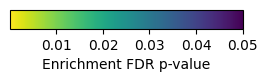

In [43]:
import matplotlib as mpl
from matplotlib import cm

fig, ax = plt.subplots(figsize=(3, 0.5))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=sen_age_overlap.BH.min(), vmax=0.05)

mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis_r)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Enrichment FDR p-value')

#plt.savefig('figures/S2B_pt2.png', dpi = 600, bbox_inches = 'tight')
#plt.savefig('figures/S2B_pt2.svg', bbox_inches = 'tight')

plt.show()

/tmp/ipykernel_3459472/3764454841.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="per_sen", y="tissue_cell", data=sen_age_overlap,
/tmp/ipykernel_3459472/3764454841.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x="per_sen", y="tissue_cell", data=sen_age_overlap,


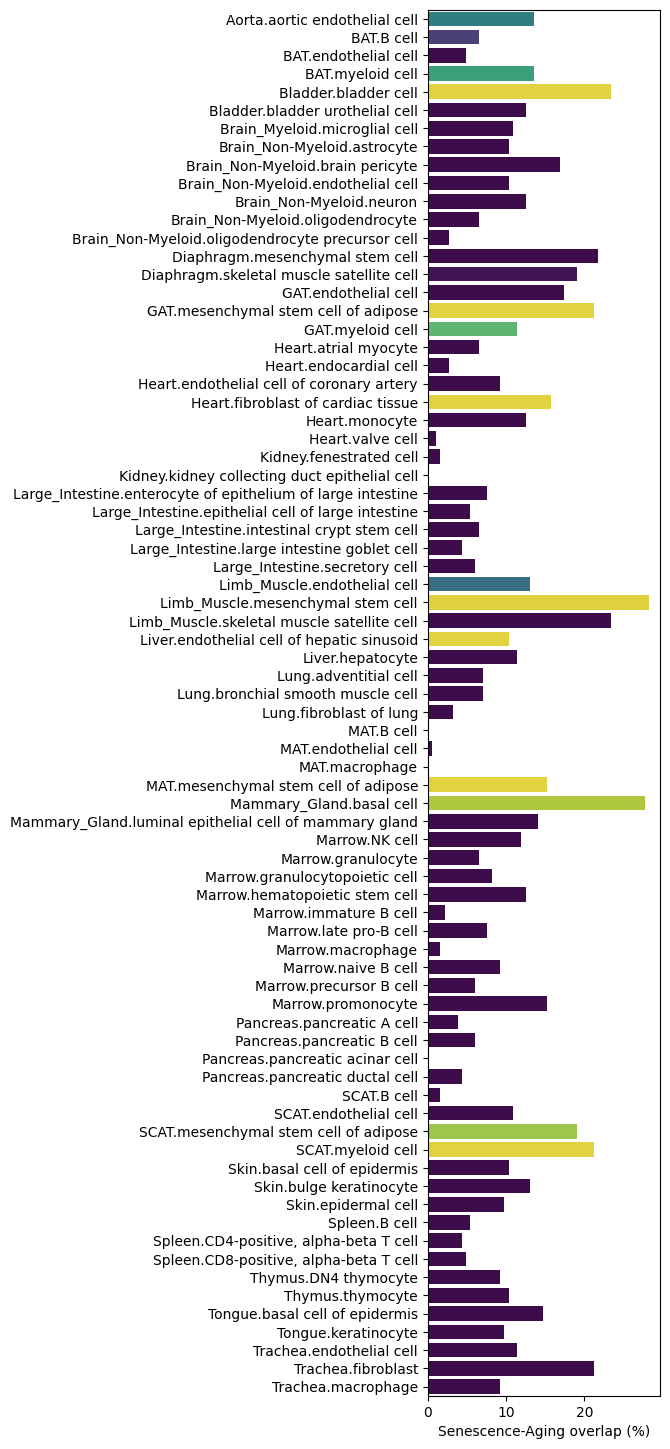

In [44]:
plt.figure(figsize=(3,18))



ax = sns.barplot(x="per_sen", y="tissue_cell", data=sen_age_overlap,
                 palette = mapper.to_rgba(sen_age_overlap.BH.values))



plt.ylabel('')
plt.xlabel('Senescence-Aging overlap (%)')


#plt.savefig('figures/S2B_pt1.png', dpi = 600, bbox_inches = 'tight')
#plt.savefig('figures/S2B_pt1.svg', bbox_inches = 'tight')
plt.show()

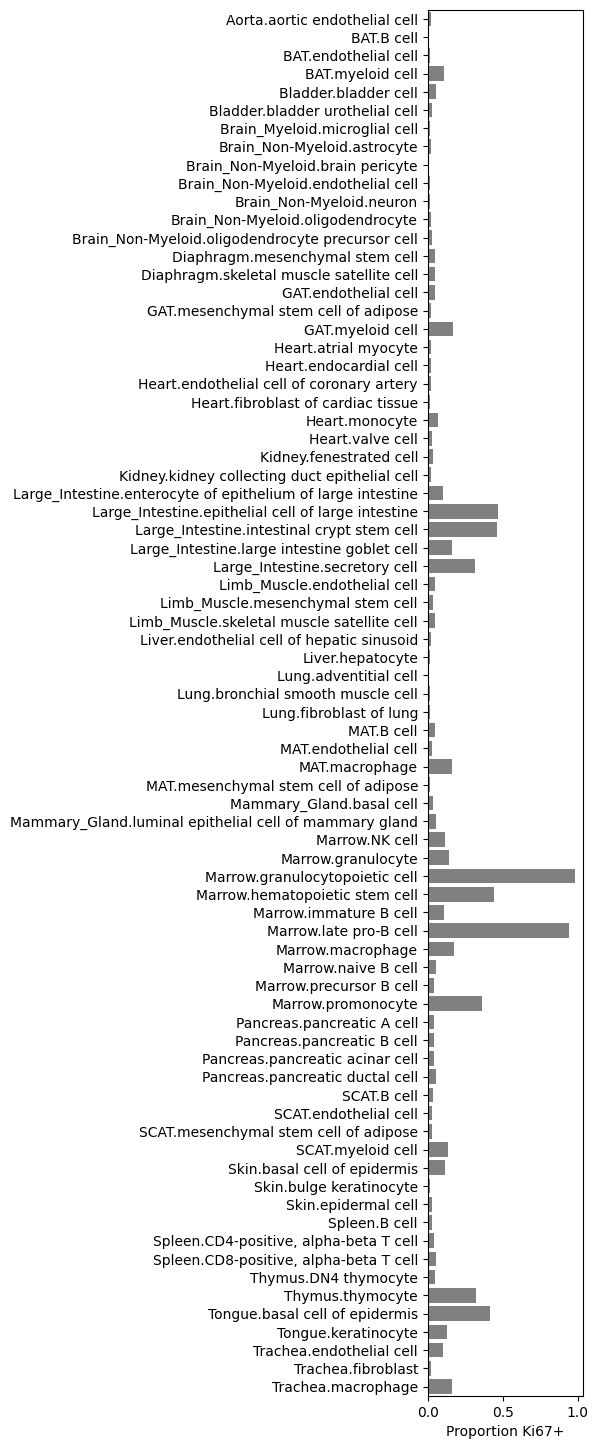

In [45]:
plt.figure(figsize=(2,18))



ax = sns.barplot(x="ppki67", y="tissue_cell", data=sen_age_overlap, color = 'grey')

plt.ylabel('')
plt.xlabel('Proportion Ki67+')


#plt.savefig('figures/S2B_pt3.png', dpi = 600, bbox_inches = 'tight')
#plt.savefig('figures/S2B_pt3.svg', bbox_inches = 'tight')
plt.show()

### Sup Figure 2C

In [46]:
sen_age_overlap['nlogp'] = -np.log10(sen_age_overlap.geo_p)

In [47]:
sen_age_overlap

,tissue_cell,aging_genes,overlap,geo_p,genes,per_a_to_s,per_sen,tissue,BH,Order,ppki67,cc_score,nlogp
0,Aorta.aortic endothelial cell,1300,25,3.421669e-04,"0610009O20Rik,1190002H23Rik,1200011M11Rik,1700...",1.923077,13.586957,Aorta,0.026005,0,0.019272,0.162791,3.465762
1,BAT.B cell,424,12,5.516384e-04,"1110003E01Rik,1110057K04Rik,1500003O03Rik,2010...",2.830189,6.521739,BAT,0.041925,1,0.011342,0.162791,3.258346
2,BAT.endothelial cell,487,9,3.555494e-02,"0610007C21Rik,0610012G03Rik,1110003E01Rik,1110...",1.848049,4.891304,BAT,2.702175,2,0.016949,0.162791,1.449100
3,BAT.myeloid cell,1270,25,2.408344e-04,"0610007C21Rik,1100001G20Rik,1110005A03Rik,1110...",1.968504,13.586957,BAT,0.018303,3,0.111842,0.162791,3.618282
4,Bladder.bladder cell,1999,43,7.490523e-08,"0610007N19Rik,0610031J06Rik,1110002B05Rik,1110...",2.151076,23.369565,Bladder,0.000006,4,0.052372,0.162791,7.125488
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Tongue.basal cell of epidermis,2941,27,5.238363e-01,"0610009D07Rik,0610011L14Rik,0610031J06Rik,0910...",0.918055,14.673913,Tongue,39.811560,71,0.415028,0.162791,0.280804
72,Tongue.keratinocyte,2583,18,9.167467e-01,"0610009D07Rik,0610011L14Rik,0610037L13Rik,0910...",0.696864,9.782609,Tongue,69.672752,72,0.126572,0.162791,0.037751
73,Trachea.endothelial cell,1725,21,1.087476e-01,"0610031J06Rik,1110003E01Rik,1110018J18Rik,1110...",1.217391,11.413043,Trachea,8.264815,73,0.099585,0.162791,0.963580
74,Trachea.fibroblast,2587,39,1.045912e-03,"0610007L01Rik,0610007N19Rik,0610010K14Rik,0910...",1.507538,21.195652,Trachea,0.079489,74,0.025081,0.162791,2.980505


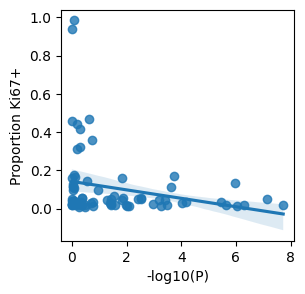

In [48]:
plt.figure(figsize=(3,3))

ax = sns.regplot(data = sen_age_overlap, x = 'nlogp', y = 'ppki67')


plt.xlabel('-log10(P)')
plt.ylabel('Proportion Ki67+')


#plt.savefig('figures/S2C.png', dpi = 600, bbox_inches = 'tight')
#plt.savefig('figures/S2C.svg', bbox_inches = 'tight')
plt.show()

In [49]:
stats.pearsonr(sen_age_overlap['nlogp'], sen_age_overlap['ppki67'])

PearsonRResult(statistic=-0.2384048917683197, pvalue=0.03808613057981084)

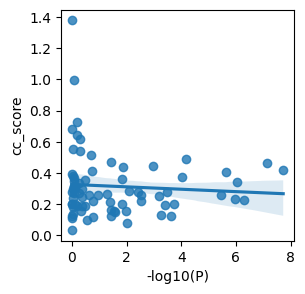

In [60]:
plt.figure(figsize=(3,3))

ax = sns.regplot(data = sen_age_overlap, x = 'nlogp', y = 'cc_score')


plt.xlabel('-log10(P)')
plt.ylabel('cc_score')


plt.savefig('figures/R1_S2D.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_S2D.svg', bbox_inches = 'tight')
plt.show()

In [61]:
stats.pearsonr(sen_age_overlap['nlogp'], sen_age_overlap['cc_score'])

PearsonRResult(statistic=-0.07226700489724526, pvalue=0.5350077579701363)

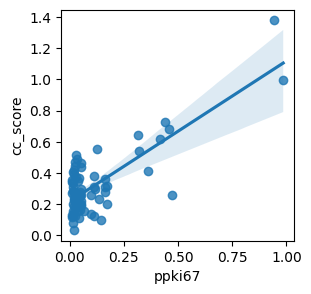

In [57]:
plt.figure(figsize=(3,3))

ax = sns.regplot(data = sen_age_overlap, x = 'ppki67', y = 'cc_score')


plt.xlabel('ppki67')
plt.ylabel('cc_score')


#plt.savefig('figures/S2C.png', dpi = 600, bbox_inches = 'tight')
#plt.savefig('figures/S2C.svg', bbox_inches = 'tight')
plt.show()

In [59]:
stats.pearsonr(sen_age_overlap['ppki67'], sen_age_overlap['cc_score'])

PearsonRResult(statistic=0.7830839577711892, pvalue=6.377675899764872e-17)